In [1]:
import numpy as np
import pandas as pd
import os
print(os.listdir("../predict_future_sales/input/"))
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

['sales_train.csv', 'Untitled.ipynb', 'shops.csv', 'test.csv', 'item_categories.csv', 'items.csv', 'sample_submission.csv']


In [2]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [3]:
pd.get_option("display.max_columns")

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 120)
#現在の最大表示行数の出力
pd.get_option("display.max_rows")

#最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 300)

In [4]:
DATA_FOLDER = '../predict_future_sales/input'

transactions = pd.read_csv('input/sales_train.csv')
items = pd.read_csv('input/items.csv')
item_categories = pd.read_csv('input/item_categories.csv')
shops = pd.read_csv(os.path.join(DATA_FOLDER,'shops.csv'))


In [5]:
test = pd.read_csv(os.path.join(DATA_FOLDER,'test.csv'))

In [6]:
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


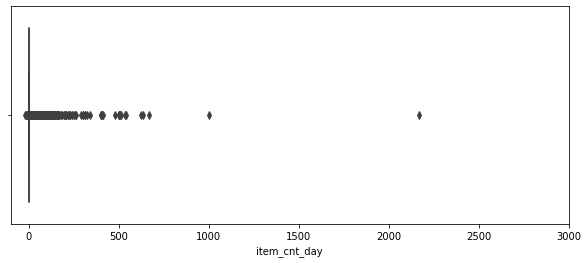

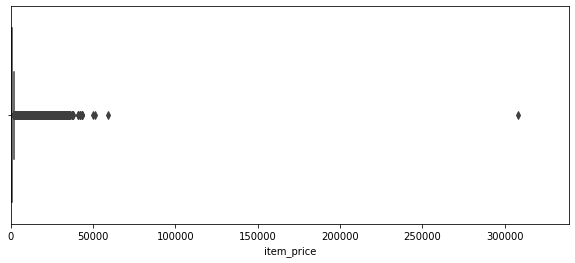

In [7]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=transactions.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(transactions.item_price.min(), transactions.item_price.max()*1.1)
sns.boxplot(x=transactions.item_price)

In [8]:
transactions = transactions[transactions.item_cnt_day < 1001]
transactions  = transactions[transactions.item_price < 100000]

In [9]:
items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
item_categories.head(5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [11]:
shops.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [12]:
shops['city_name'] = shops['shop_name'].map(lambda x:x.split(' ')[0])
shops['city_name'].value_counts()

Москва              13
РостовНаДону         3
Воронеж              3
Тюмень               3
Казань               2
Якутск               2
!Якутск              2
Н.Новгород           2
Самара               2
СПб                  2
Уфа                  2
Новосибирск          2
Жуковский            2
Красноярск           2
Вологда              1
Мытищи               1
Томск                1
Адыгея               1
Калуга               1
Балашиха             1
Коломна              1
Выездная             1
Омск                 1
Сургут               1
Волжский             1
Химки                1
Ярославль            1
Цифровой             1
Интернет-магазин     1
Чехов                1
Сергиев              1
Курск                1
Name: city_name, dtype: int64

In [13]:
shops.loc[shops['city_name'] == '!Якутск', 'city_name'] = 'Якутск'
shops.city_name.value_counts()

Москва              13
Якутск               4
РостовНаДону         3
Воронеж              3
Тюмень               3
Казань               2
Н.Новгород           2
Самара               2
СПб                  2
Уфа                  2
Новосибирск          2
Жуковский            2
Красноярск           2
Вологда              1
Выездная             1
Томск                1
Адыгея               1
Калуга               1
Балашиха             1
Мытищи               1
Коломна              1
Омск                 1
Сургут               1
Ярославль            1
Цифровой             1
Химки                1
Интернет-магазин     1
Курск                1
Чехов                1
Волжский             1
Сергиев              1
Name: city_name, dtype: int64

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [15]:
item_categories['split'] = item_categories['item_category_name'].str.split(' - ')
item_categories['type'] = item_categories['split'].map(lambda x:x[0].strip())
item_categories['subtype'] = item_categories['split'].map(lambda x:x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['type'] = le.fit_transform(item_categories['type'])
item_categories['subtype'] = le.fit_transform(item_categories['subtype'])

item_categories = item_categories[['type','subtype','item_category_id']]

In [16]:
shops['city_name'] = le.fit_transform(shops['city_name'])

encoding = shops.groupby('city_name').size()
encoding = encoding / len(shops)
shops['city_frequency'] = shops.city_name.map(encoding)
shops.city_frequency.describe()

# encoding = test.groupby('item_id').size()
# encoding = encoding/len(test)
# test['item_freq'] = test.item_id.map(encoding)

# encoding = transactions.groupby('item_id').size()
# encoding = encoding/len(transactions)
# transactions['item_freq'] = transactions.item_id.map(encoding)

count    60.000000
mean      0.072778
std       0.077628
min       0.016667
25%       0.016667
50%       0.033333
75%       0.066667
max       0.216667
Name: city_frequency, dtype: float64

In [17]:
transactions = pd.merge(transactions, items, on='item_id', how='left')
transactions = transactions.drop('item_name',axis=1)
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [18]:
transactions = pd.merge(transactions, shops, on='shop_id', how='left')
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,shop_name,city_name,city_frequency
0,02.01.2013,0,59,22154,999.00,1.0,37,"Ярославль ТЦ ""Альтаир""",30,0.016667
1,03.01.2013,0,25,2552,899.00,1.0,58,"Москва ТРК ""Атриум""",13,0.216667
2,05.01.2013,0,25,2552,899.00,-1.0,58,"Москва ТРК ""Атриум""",13,0.216667
3,06.01.2013,0,25,2554,1709.05,1.0,58,"Москва ТРК ""Атриум""",13,0.216667
4,15.01.2013,0,25,2555,1099.00,1.0,56,"Москва ТРК ""Атриум""",13,0.216667


In [19]:
from itertools import product
index_col = ['shop_id','item_id','date_block_num']

In [20]:
grid = []
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    #This shows all shops in three countries working in each month
    cur_items = transactions.loc[transactions['date_block_num']==block_num,'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops,cur_items,[block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid),columns=index_col,dtype=np.int32)
grid.head(15)

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
5,59,2565,0
6,59,2572,0
7,59,2573,0
8,59,2574,0
9,59,2593,0


## Make statistical features

In [21]:
mean_transactions = transactions.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()

mean_transactions.head(5)

,date_block_num,shop_id,item_id,item_cnt_day,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


In [22]:
mean_transactions.columns = ['date_block_num','shop_id','item_id','item_cnt_month','item_price']

In [23]:
mean_transactions.item_cnt_month.describe()

count    1.609123e+06
mean     2.265853e+00
std      8.466196e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.644000e+03
Name: item_cnt_month, dtype: float64

In [24]:
mean_transactions.item_cnt_month = mean_transactions.item_cnt_month.clip(0,20)
mean_transactions.item_cnt_month.describe()

count    1.609123e+06
mean     2.022807e+00
std      2.577964e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+01
Name: item_cnt_month, dtype: float64

In [25]:
mean_transactions = pd.merge(grid, mean_transactions, on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0
5,59,2565,0,0.0,0.0
6,59,2572,0,0.0,0.0
7,59,2573,0,0.0,0.0
8,59,2574,0,2.0,399.0
9,59,2593,0,0.0,0.0


In [26]:
mean_transactions = pd.merge(mean_transactions, items, on='item_id',how='left')
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55


In [27]:
shops.drop('shop_name',axis=1,inplace=True)
shops['city_name'].value_counts()

13    13
29     4
24     3
4      3
18     3
15     2
19     2
8      2
16     2
20     2
6      2
25     2
11     2
10     1
5      1
7      1
3      1
2      1
1      1
9      1
30     1
12     1
14     1
17     1
21     1
22     1
23     1
26     1
27     1
28     1
0      1
Name: city_name, dtype: int64

In [28]:
mean_transactions = pd.merge(mean_transactions, shops, on=['shop_id'], how='left')

In [29]:
mean_transactions = pd.merge(mean_transactions, item_categories, on = ['item_category_id'], how='left')

In [30]:
import gc 

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [31]:
transactions['sales'] = transactions['item_cnt_day'] * transactions['item_price']

In [32]:
mean_transactions['product_sales'] = mean_transactions['item_cnt_month'] * mean_transactions['item_price']

## I will make the similar dataframe about statistical features, but this time, these are lag features

In [33]:
item_mean = transactions.groupby(['item_id','date_block_num']).mean().reset_index()\
                        [['item_id','item_price','item_cnt_day','date_block_num','sales']]
item_mean.columns = ['item_id','item_price_per_item','item_cnt_day_per_item','date_block_num','sales_per_item']



item_std =transactions.groupby(['item_id','date_block_num']).std().reset_index()\
                        [['item_id','item_price','item_cnt_day','date_block_num','sales']]
item_std.columns = ['item_id','price_std_per_item','cnt_day_std_per_item','date_block_num','sales_std_per_item']

In [34]:
mean_transactions = pd.merge(mean_transactions, item_mean, on=['date_block_num','item_id'],how='left')
mean_transactions = pd.merge(mean_transactions, item_std, on=['date_block_num','item_id'],how='left')
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,city_name,city_frequency,type,subtype,product_sales,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,30,0.016667,11,1,999.0,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,30,0.016667,13,29,0.0,899.000000,0.000000,0.000000,0.000000,1.414214,1271.377993
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,30,0.016667,13,29,0.0,1709.050000,1.000000,1709.050000,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,30,0.016667,13,5,0.0,1098.850000,1.000000,1098.850000,0.212132,0.000000,0.212132
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,30,0.016667,13,42,0.0,327.600000,1.000000,327.600000,47.851855,0.000000,47.851855
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,30,0.016667,13,5,0.0,549.000000,1.000000,549.000000,0.000000,0.000000,0.000000
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,30,0.016667,13,4,0.0,284.333333,1.000000,284.333333,36.275044,0.000000,36.275044
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,30,0.016667,13,4,0.0,299.000000,1.142857,341.714286,0.000000,0.534522,159.822223
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,30,0.016667,13,4,798.0,392.986538,1.144231,450.534615,25.217555,0.379531,155.777822
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,30,0.016667,13,4,0.0,254.200000,1.000000,254.200000,55.454486,0.000000,55.454486


In [35]:
mean_transactions = downcast_dtypes(mean_transactions)

In [36]:
del item_mean

In [37]:
shop_mean_df = transactions.groupby(['date_block_num','shop_id']).mean().reset_index()\
                                 [['shop_id','date_block_num','item_cnt_day','item_price','sales']]
shop_mean_df.columns = ['shop_id','date_block_num','item_cnt_day_per_shop','item_price_per_shop','sales_per_shop']
mean_transactions = pd.merge(mean_transactions,shop_mean_df, on=['date_block_num','shop_id'],how='left')

shop_std_df =  transactions.groupby(['date_block_num','shop_id']).std().reset_index()\
                                 [['shop_id','date_block_num','item_cnt_day','item_price','sales']]
shop_std_df.columns = ['shop_id','date_block_num','cnt_day_std_shop','price_std_per_shop','sales_std_per_shop']
mean_transactions = pd.merge(mean_transactions,shop_std_df, on=['date_block_num','shop_id'],how='left')

In [38]:
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,city_name,city_frequency,type,subtype,product_sales,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item,item_cnt_day_per_shop,item_price_per_shop,sales_per_shop,cnt_day_std_shop,price_std_per_shop,sales_std_per_shop
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,30,0.016667,11,1,999.0,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,30,0.016667,13,29,0.0,899.000000,0.000000,0.000000,0.000000,1.414214,1271.378052,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,30,0.016667,13,29,0.0,1709.050049,1.000000,1709.050049,NaN,NaN,NaN,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,30,0.016667,13,5,0.0,1098.849976,1.000000,1098.849976,0.212132,0.000000,0.212132,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,30,0.016667,13,42,0.0,327.600006,1.000000,327.600006,47.851856,0.000000,47.851856,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,30,0.016667,13,5,0.0,549.000000,1.000000,549.000000,0.000000,0.000000,0.000000,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,30,0.016667,13,4,0.0,284.333344,1.000000,284.333344,36.275043,0.000000,36.275043,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,30,0.016667,13,4,0.0,299.000000,1.142857,341.714294,0.000000,0.534522,159.822220,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,30,0.016667,13,4,798.0,392.986542,1.144231,450.534607,25.217554,0.379531,155.777817,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,30,0.016667,13,4,0.0,254.199997,1.000000,254.199997,55.454487,0.000000,55.454487,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779


In [39]:
category_mean_df = transactions.groupby(['date_block_num','item_category_id']).mean().reset_index()[['item_category_id','date_block_num','item_cnt_day','item_price','sales']]
category_mean_df.columns = ['item_category_id','date_block_num','item_cnt_day_per_category','item_price_per_category','sales_per_category']
mean_transactions = pd.merge(mean_transactions, category_mean_df, on=['date_block_num','item_category_id'],how='left')

In [40]:
category_mean_df = transactions.groupby(['date_block_num','item_category_id']).std().reset_index()[['item_category_id','date_block_num','item_cnt_day','item_price','sales']]
category_mean_df.columns = ['item_category_id','date_block_num','cnt_day_std_per_category','price_std_per_category','sales_std_per_category']
mean_transactions = pd.merge(mean_transactions, category_mean_df, on=['date_block_num','item_category_id'],how='left')

In [41]:
shop_cat_df = transactions.groupby(['date_block_num', 'item_category_id', 'shop_id']).mean().reset_index()\
                          [['date_block_num', 'item_category_id', 'shop_id','item_cnt_day','item_price']]
shop_cat_df.columns = ['date_block_num','item_category_id','shop_id','cnt_day_shop_cat','price_shop_cat']
mean_transactions = pd.merge(mean_transactions, shop_cat_df, on=['date_block_num', 'item_category_id','shop_id'], how='left')

In [42]:
mean_transactions = downcast_dtypes(mean_transactions)
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,city_name,city_frequency,type,subtype,product_sales,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item,item_cnt_day_per_shop,item_price_per_shop,sales_per_shop,cnt_day_std_shop,price_std_per_shop,sales_std_per_shop,item_cnt_day_per_category,item_price_per_category,sales_per_category,cnt_day_std_per_category,price_std_per_category,sales_std_per_category,cnt_day_shop_cat,price_shop_cat
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,30,0.016667,11,1,999.0,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.053414,465.036011,491.797668,0.385709,334.376770,398.859619,1.016949,451.226776
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,30,0.016667,13,29,0.0,899.000000,0.000000,0.000000,0.000000,1.414214,1271.378052,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,30,0.016667,13,29,0.0,1709.050049,1.000000,1709.050049,NaN,NaN,NaN,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,30,0.016667,13,5,0.0,1098.849976,1.000000,1098.849976,0.212132,0.000000,0.212132,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.007519,867.447021,876.650024,0.086547,335.257874,361.018921,1.000000,1299.000000
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,30,0.016667,13,42,0.0,327.600006,1.000000,327.600006,47.851856,0.000000,47.851856,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.990113,443.330017,433.212769,0.202288,465.695496,484.760101,1.000000,1274.000000
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,30,0.016667,13,5,0.0,549.000000,1.000000,549.000000,0.000000,0.000000,0.000000,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.007519,867.447021,876.650024,0.086547,335.257874,361.018921,1.000000,1299.000000
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,30,0.016667,13,4,0.0,284.333344,1.000000,284.333344,36.275043,0.000000,36.275043,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,30,0.016667,13,4,0.0,299.000000,1.142857,341.714294,0.000000,0.534522,159.822220,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,30,0.016667,13,4,798.0,392.986542,1.144231,450.534607,25.217554,0.379531,155.777817,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,30,0.016667,13,4,0.0,254.199997,1.000000,254.199997,55.454487,0.000000,55.454487,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130


In [43]:
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,city_name,city_frequency,type,subtype,product_sales,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item,item_cnt_day_per_shop,item_price_per_shop,sales_per_shop,cnt_day_std_shop,price_std_per_shop,sales_std_per_shop,item_cnt_day_per_category,item_price_per_category,sales_per_category,cnt_day_std_per_category,price_std_per_category,sales_std_per_category,cnt_day_shop_cat,price_shop_cat
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,30,0.016667,11,1,999.0,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.053414,465.036011,491.797668,0.385709,334.376770,398.859619,1.016949,451.226776
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,30,0.016667,13,29,0.0,899.000000,0.000000,0.000000,0.000000,1.414214,1271.378052,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,30,0.016667,13,29,0.0,1709.050049,1.000000,1709.050049,NaN,NaN,NaN,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,30,0.016667,13,5,0.0,1098.849976,1.000000,1098.849976,0.212132,0.000000,0.212132,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.007519,867.447021,876.650024,0.086547,335.257874,361.018921,1.000000,1299.000000
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,30,0.016667,13,42,0.0,327.600006,1.000000,327.600006,47.851856,0.000000,47.851856,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.990113,443.330017,433.212769,0.202288,465.695496,484.760101,1.000000,1274.000000
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,30,0.016667,13,5,0.0,549.000000,1.000000,549.000000,0.000000,0.000000,0.000000,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.007519,867.447021,876.650024,0.086547,335.257874,361.018921,1.000000,1299.000000
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,30,0.016667,13,4,0.0,284.333344,1.000000,284.333344,36.275043,0.000000,36.275043,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,30,0.016667,13,4,0.0,299.000000,1.142857,341.714294,0.000000,0.534522,159.822220,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,30,0.016667,13,4,798.0,392.986542,1.144231,450.534607,25.217554,0.379531,155.777817,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,30,0.016667,13,4,0.0,254.199997,1.000000,254.199997,55.454487,0.000000,55.454487,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130


In [44]:
type_df = mean_transactions.groupby(['date_block_num','type']).mean().reset_index()\
                [['date_block_num','type','item_cnt_month','item_price']]
type_df.columns = ['date_block_num','type','item_cnt_month_per_type','item_price_per_type']
mean_transactions = pd.merge(mean_transactions, type_df, on=['date_block_num','type'],how='left')

In [45]:
city_df = mean_transactions.groupby(['date_block_num','city_name']).mean().reset_index()\
                [['date_block_num','city_name','item_cnt_month','item_price']]
city_df.columns = ['date_block_num','city_name','item_cnt_day_city','item_price_city']
mean_transactions = pd.merge(mean_transactions, city_df, on=['date_block_num','city_name'], how='left')

In [46]:
cat_city_df = mean_transactions.groupby(['date_block_num','city_name','item_category_id']).mean().reset_index()\
                [['date_block_num','city_name','item_category_id','item_cnt_month','item_price']]
cat_city_df.columns = ['date_block_num','city_name','item_category_id','item_cnt_day_city_cat','item_price_city_cat']
mean_transactions = pd.merge(mean_transactions, cat_city_df, on=['date_block_num','city_name','item_category_id'], how='left')

## Create Lag features 

In [47]:
#These are variables which are presented as lag features
lag_variables = list(mean_transactions.columns[11:]) + ['item_cnt_month']

lags= [1,2,3,6]
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id'] + lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id'] + [lag_fest+'_lag_'+ str(lag) for lag_fest in lag_variables]
    mean_transactions = pd.merge(mean_transactions, sales_new_df, on = ['date_block_num','shop_id','item_id'],how='left')
    del sales_new_df

In [48]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col + '_lag_' + str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on = ['date_block_num','shop_id','item_id'] , how='left')
    return df

In [49]:
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,city_name,city_frequency,type,subtype,product_sales,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item,item_cnt_day_per_shop,item_price_per_shop,sales_per_shop,cnt_day_std_shop,price_std_per_shop,sales_std_per_shop,item_cnt_day_per_category,item_price_per_category,sales_per_category,cnt_day_std_per_category,price_std_per_category,sales_std_per_category,cnt_day_shop_cat,price_shop_cat,item_cnt_month_per_type,item_price_per_type,item_cnt_day_city,item_price_city,item_cnt_day_city_cat,item_price_city_cat,product_sales_lag_1,item_price_per_item_lag_1,item_cnt_day_per_item_lag_1,sales_per_item_lag_1,price_std_per_item_lag_1,cnt_day_std_per_item_lag_1,sales_std_per_item_lag_1,item_cnt_day_per_shop_lag_1,item_price_per_shop_lag_1,sales_per_shop_lag_1,cnt_day_std_shop_lag_1,price_std_per_shop_lag_1,sales_std_per_shop_lag_1,item_cnt_day_per_category_lag_1,item_price_per_category_lag_1,sales_per_category_lag_1,cnt_day_std_per_category_lag_1,price_std_per_category_lag_1,sales_std_per_category_lag_1,cnt_day_shop_cat_lag_1,price_shop_cat_lag_1,item_cnt_month_per_type_lag_1,...,item_price_city_lag_2,item_cnt_day_city_cat_lag_2,item_price_city_cat_lag_2,item_cnt_month_lag_2,product_sales_lag_3,item_price_per_item_lag_3,item_cnt_day_per_item_lag_3,sales_per_item_lag_3,price_std_per_item_lag_3,cnt_day_std_per_item_lag_3,sales_std_per_item_lag_3,item_cnt_day_per_shop_lag_3,item_price_per_shop_lag_3,sales_per_shop_lag_3,cnt_day_std_shop_lag_3,price_std_per_shop_lag_3,sales_std_per_shop_lag_3,item_cnt_day_per_category_lag_3,item_price_per_category_lag_3,sales_per_category_lag_3,cnt_day_std_per_category_lag_3,price_std_per_category_lag_3,sales_std_per_category_lag_3,cnt_day_shop_cat_lag_3,price_shop_cat_lag_3,item_cnt_month_per_type_lag_3,item_price_per_type_lag_3,item_cnt_day_city_lag_3,item_price_city_lag_3,item_cnt_day_city_cat_lag_3,item_price_city_cat_lag_3,item_cnt_month_lag_3,product_sales_lag_6,item_price_per_item_lag_6,item_cnt_day_per_item_lag_6,sales_per_item_lag_6,price_std_per_item_lag_6,cnt_day_std_per_item_lag_6,sales_std_per_item_lag_6,item_cnt_day_per_shop_lag_6,item_price_per_shop_lag_6,sales_per_shop_lag_6,cnt_day_std_shop_lag_6,price_std_per_shop_lag_6,sales_std_per_shop_lag_6,item_cnt_day_per_category_lag_6,item_price_per_category_lag_6,sales_per_category_lag_6,cnt_day_std_per_category_lag_6,price_std_per_category_lag_6,sales_std_per_category_lag_6,cnt_day_shop_cat_lag_6,price_shop_cat_lag_6,item_cnt_month_per_type_lag_6,item_price_per_type_lag_6,item_cnt_day_city_lag_6,item_price_city_lag_6,item_cnt_day_city_cat_lag_6,item_price_city_cat_lag_6,item_cnt_month_lag_6
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,30,0.016667,11,1,999.0,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.053414,465.036011,491.797668,0.385709,334.376770,398.859619,1.016949,451.226776,0.271804,54.498623,0.246827,97.974472,0.088496,35.484188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,30,0.016667,13,29,0.0,899.000000,0.000000,0.000000,0.000000,1.414214,1271.378052,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN,0.166505,40.706470,0.246827,97.974472,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [50]:
mean_transactions = mean_transactions[mean_transactions['date_block_num'] > 12]

In [51]:
# encoder = mean_transactions.groupby('item_id').size()
# encoder = encoder/len(mean_transactions)

# mean_transactions['item_freq'] = mean_transactions['item_id'].map(encoder)

In [52]:
for feat in mean_transactions.columns:
    if 'cnt' in feat:
        mean_transactions[feat] = mean_transactions[feat].fillna(0)
    elif 'price' in feat:
        mean_transactions[feat] = mean_transactions[feat].fillna(mean_transactions[feat].median())

In [53]:
lag_variables.remove('item_cnt_month')
lag_variables

['product_sales',
 'item_price_per_item',
 'item_cnt_day_per_item',
 'sales_per_item',
 'price_std_per_item',
 'cnt_day_std_per_item',
 'sales_std_per_item',
 'item_cnt_day_per_shop',
 'item_price_per_shop',
 'sales_per_shop',
 'cnt_day_std_shop',
 'price_std_per_shop',
 'sales_std_per_shop',
 'item_cnt_day_per_category',
 'item_price_per_category',
 'sales_per_category',
 'cnt_day_std_per_category',
 'price_std_per_category',
 'sales_std_per_category',
 'cnt_day_shop_cat',
 'price_shop_cat',
 'item_cnt_month_per_type',
 'item_price_per_type',
 'item_cnt_day_city',
 'item_price_city',
 'item_cnt_day_city_cat',
 'item_price_city_cat']

In [54]:
cols_to_drop = lag_variables + ['item_price','item_name']
cols_to_drop

['product_sales',
 'item_price_per_item',
 'item_cnt_day_per_item',
 'sales_per_item',
 'price_std_per_item',
 'cnt_day_std_per_item',
 'sales_std_per_item',
 'item_cnt_day_per_shop',
 'item_price_per_shop',
 'sales_per_shop',
 'cnt_day_std_shop',
 'price_std_per_shop',
 'sales_std_per_shop',
 'item_cnt_day_per_category',
 'item_price_per_category',
 'sales_per_category',
 'cnt_day_std_per_category',
 'price_std_per_category',
 'sales_std_per_category',
 'cnt_day_shop_cat',
 'price_shop_cat',
 'item_cnt_month_per_type',
 'item_price_per_type',
 'item_cnt_day_city',
 'item_price_city',
 'item_cnt_day_city_cat',
 'item_price_city_cat',
 'item_price',
 'item_name']

## Trend features 

In [55]:
# group = mean_transactions.groupby(['item_id']).agg({'item_price':['mean']})
# group.columns = ['item_avg_item_price']
# group.reset_index(inplace=True)

# mean_transactions = pd.merge(mean_transactions, group, on=['item_id'], how='left')
# mean_transactions['item_avg_item_price'] = mean_transactions['item_avg_item_price'].astype(np.float16)
# lags  = [1,2,3,6]
# for i in lags:
#     mean_transactions['delta_price_lag_' + str(i)] = \
#     (mean_transactions['item_price_per_item_' + str(i)] - mean_transactions['item_avg_item_price'])/mean_transactions['item_avg_item_price']

# def select_trend(row):
#     for i in lags:
#         if row['delta_price_lag_' + str(i)]:
#             return row['delta_price_lag_' + str(i)]
#     return 0

# mean_transactions['delta_price_lag'] = mean_transactions.apply(select_trend, axis=1)
# #各行に対して最近のlag特徴量と平均値の差を計算し、その商品がどれほどホットなのかを計算する。
# mean_transactions['delta_price_lag'] = mean_transactions['delta_price_lag'].astype(np.float16).fillna(0, inplace=True)
# features_to_drop = ['item_avg_item_price']



## Special Features

In [56]:
mean_transactions['month'] = mean_transactions['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
mean_transactions['days'] = mean_transactions['month'].map(days).astype(np.int8)

In [57]:
training = mean_transactions.drop(cols_to_drop,axis=1)

In [58]:
import xgboost as xgb

In [59]:
len(training.columns)

123

In [60]:
training.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,city_name,city_frequency,type,subtype,product_sales_lag_1,item_price_per_item_lag_1,item_cnt_day_per_item_lag_1,sales_per_item_lag_1,price_std_per_item_lag_1,cnt_day_std_per_item_lag_1,sales_std_per_item_lag_1,item_cnt_day_per_shop_lag_1,item_price_per_shop_lag_1,sales_per_shop_lag_1,cnt_day_std_shop_lag_1,price_std_per_shop_lag_1,sales_std_per_shop_lag_1,item_cnt_day_per_category_lag_1,item_price_per_category_lag_1,sales_per_category_lag_1,cnt_day_std_per_category_lag_1,price_std_per_category_lag_1,sales_std_per_category_lag_1,cnt_day_shop_cat_lag_1,price_shop_cat_lag_1,item_cnt_month_per_type_lag_1,item_price_per_type_lag_1,item_cnt_day_city_lag_1,item_price_city_lag_1,item_cnt_day_city_cat_lag_1,item_price_city_cat_lag_1,item_cnt_month_lag_1,product_sales_lag_2,item_price_per_item_lag_2,item_cnt_day_per_item_lag_2,sales_per_item_lag_2,price_std_per_item_lag_2,cnt_day_std_per_item_lag_2,sales_std_per_item_lag_2,item_cnt_day_per_shop_lag_2,item_price_per_shop_lag_2,sales_per_shop_lag_2,cnt_day_std_shop_lag_2,price_std_per_shop_lag_2,sales_std_per_shop_lag_2,item_cnt_day_per_category_lag_2,item_price_per_category_lag_2,sales_per_category_lag_2,cnt_day_std_per_category_lag_2,price_std_per_category_lag_2,sales_std_per_category_lag_2,cnt_day_shop_cat_lag_2,price_shop_cat_lag_2,item_cnt_month_per_type_lag_2,item_price_per_type_lag_2,...,item_price_city_cat_lag_2,item_cnt_month_lag_2,product_sales_lag_3,item_price_per_item_lag_3,item_cnt_day_per_item_lag_3,sales_per_item_lag_3,price_std_per_item_lag_3,cnt_day_std_per_item_lag_3,sales_std_per_item_lag_3,item_cnt_day_per_shop_lag_3,item_price_per_shop_lag_3,sales_per_shop_lag_3,cnt_day_std_shop_lag_3,price_std_per_shop_lag_3,sales_std_per_shop_lag_3,item_cnt_day_per_category_lag_3,item_price_per_category_lag_3,sales_per_category_lag_3,cnt_day_std_per_category_lag_3,price_std_per_category_lag_3,sales_std_per_category_lag_3,cnt_day_shop_cat_lag_3,price_shop_cat_lag_3,item_cnt_month_per_type_lag_3,item_price_per_type_lag_3,item_cnt_day_city_lag_3,item_price_city_lag_3,item_cnt_day_city_cat_lag_3,item_price_city_cat_lag_3,item_cnt_month_lag_3,product_sales_lag_6,item_price_per_item_lag_6,item_cnt_day_per_item_lag_6,sales_per_item_lag_6,price_std_per_item_lag_6,cnt_day_std_per_item_lag_6,sales_std_per_item_lag_6,item_cnt_day_per_shop_lag_6,item_price_per_shop_lag_6,sales_per_shop_lag_6,cnt_day_std_shop_lag_6,price_std_per_shop_lag_6,sales_std_per_shop_lag_6,item_cnt_day_per_category_lag_6,item_price_per_category_lag_6,sales_per_category_lag_6,cnt_day_std_per_category_lag_6,price_std_per_category_lag_6,sales_std_per_category_lag_6,cnt_day_shop_cat_lag_6,price_shop_cat_lag_6,item_cnt_month_per_type_lag_6,item_price_per_type_lag_6,item_cnt_day_city_lag_6,item_price_city_lag_6,item_cnt_day_city_cat_lag_6,item_price_city_cat_lag_6,item_cnt_month_lag_6,month,days
4836056,27,15242,13,2.0,63,13,0.216667,14,43,699.0,670.333313,1.000000,670.333313,86.000000,0.000000,86.000000,1.282588,933.352539,1162.221069,2.013348,1470.434204,3065.484375,1.072020,784.343811,832.338440,0.373894,466.045044,538.425720,1.057692,827.057678,0.302126,106.466026,0.494742,147.031158,0.454918,166.021057,1.0,699.0,699.000000,1.000000,699.000000,0.000000,0.000000,0.000000,1.386419,1065.680542,1771.667114,1.894252,1812.540527,9735.088867,1.297745,662.071777,761.287048,1.349082,457.279510,633.040527,1.107527,776.193542,0.473799,147.920288,...,276.853394,1.0,0.0,685.00,1.000000,685.000000,44.271889,0.000000,44.271889,1.357345,892.269165,1344.281128,1.651885,1304.103882,9451.010742,1.065767,667.952271,684.672363,0.500523,419.512695,435.079193,1.056604,687.679260,0.253194,95.529648,0.467487,136.646439,0.472566,171.287354,0.0,699.0,699.0,1.000000,699.0,0.0,0.000000,0.000000,1.216049,667.358765,766.732483,1.084473,1016.664185,1269.759277,1.113456,471.065521,479.988922,0.455611,411.071411,441.469604,1.115942,549.242004,0.266098,95.968460,0.483414,129.972885,0.517054,144

In [61]:
training = downcast_dtypes(training)
test = downcast_dtypes(test)

In [62]:
X_train = training[training.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = training[training.date_block_num < 33]['item_cnt_month']
X_valid = training[training.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = training[training.date_block_num == 33]['item_cnt_month']

In [63]:
pd.Series(Y_train).describe()

count    5.839576e+06
mean     2.875133e-01
std      1.186862e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: item_cnt_month, dtype: float64

In [64]:
pd.Series(y_valid).describe()

count    238172.000000
mean          0.258565
std           1.136157
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: item_cnt_month, dtype: float64

In [65]:
xgbtrain = xgb.DMatrix(X_train.values, Y_train.values)
xgbvalid = xgb.DMatrix(X_valid.values, y_valid.values)
evals = [(xgbtrain, 'train'), (xgbvalid, 'eval')]

In [66]:
params = {
          'max_depth':10,
          'subsample':0.8,
          'min_child_weight':300,
          'colsample_bytree':0.8,
          'eta':0.3,'num_round':1000,
          'seed':1,
          'silent':0,
          'eval_metric':'rmse'
         }
bst = xgb.train(params, xgbtrain, num_boost_round=1000,early_stopping_rounds=10, evals=evals, verbose_eval=1)

[12:17:04] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-rmse:1.05811	eval-rmse:1.0503
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.979853	eval-rmse:0.995999
[2]	train-rmse:0.934305	eval-rmse:0.969686
[3]	train-rmse:0.901085	eval-rmse:0.952039
[4]	train-rmse:0.881261	eval-rmse:0.944375
[5]	train-rmse:0.869414	eval-rmse:0.938903
[6]	train-rmse:0.860096	eval-rmse:0.937259
[7]	train-rmse:0.853074	eval-rmse:0.931341
[8]	train-rmse:0.849195	eval-rmse:0.930323
[9]	train-rmse:0.842892	eval-rmse:0.928729
[10]	train-rmse:0.837169	eval-rmse:0.931557
[11]	train-rmse:0.834153	eval-rmse:0.931728
[12]	train-rmse:0.831875	eval-rmse:0.931059
[13]	train-rmse:0.829754	eval-rmse:0.929496
[14]	train-rmse:0.827182	eval-rmse:0.931071
[15]	tr

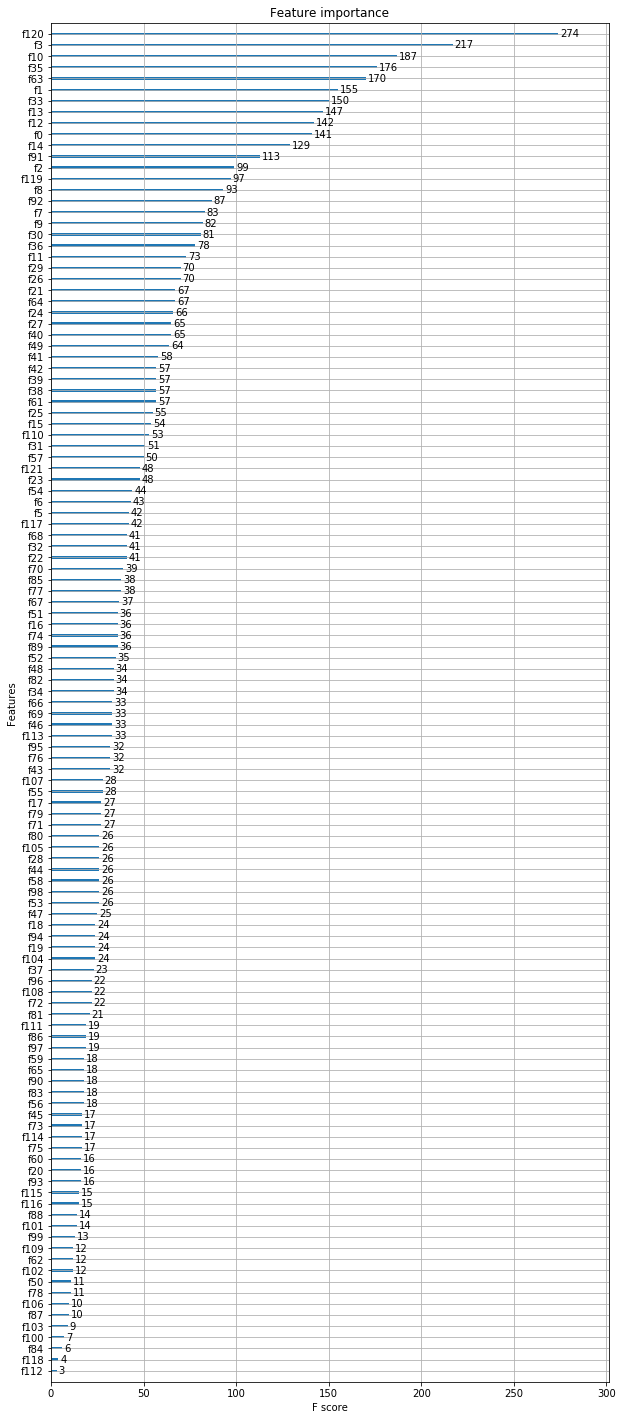

In [67]:
plot_features(bst, (10,25))

In [108]:
cols = list(training.columns)

del cols[cols.index('item_cnt_month')]
[cols[x] for x in [120,3,10,35,63,1,33,13,12]]

['month',
 'item_category_id',
 'item_cnt_day_per_item_lag_1',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_id',
 'item_cnt_day_city_cat_lag_1',
 'cnt_day_std_per_item_lag_1',
 'price_std_per_item_lag_1']

In [69]:
xgb_val_predict = xgb.DMatrix(X_valid.values)
val_pred = bst.predict(xgb_val_predict)

pd.Series(val_pred).describe()

count    238172.000000
mean          0.286401
std           0.740462
min          -0.442589
25%           0.036118
50%           0.111304
75%           0.250869
max          20.881985
dtype: float64

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [71]:
category_feat = ['item_id','shop_id','item_category_id']

In [72]:
# X_train_lr = training.drop(category_feat + ['item_cnt_month'], axis=1)

# for feat in X_train_lr.columns:
#     X_train_lr[feat] = X_train_lr[feat].fillna(X_train_lr[feat].median())

In [73]:
# X_train_lr.date_block_num = X_train_lr.date_block_num.astype(str)
# X_train_lr.to_csv('lr_dataframe.csv',index=False)
# X_train_lr.date_block_num = pd.get_dummies(X_train_lr.date_block_num,sparse=False)      
# scaler = preprocessing.StandardScaler()

# X_train_lr = scaler.fit_transform(X_train_lr)

In [74]:
# lr = LinearRegression()

# lr.fit(X_train_lr, training['item_cnt_month'])

In [75]:
#ensembleのためにｃｓｖファイルに保存する
# training.to_csv('xgb_dataframe.csv',index=False)

In [76]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [77]:
 test['date_block_num'] = 34

In [78]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [79]:
test = pd.merge(test, items, on=['item_id'], how='left')

In [80]:
test = pd.merge(test, shops, on=['shop_id'], how='left')

In [81]:
test = pd.merge(test,item_categories, on=['item_category_id'], how='left')

In [82]:
lag_variables.append('item_cnt_month')
for lag in tqdm_notebook(lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num', 'shop_id','item_id'] + lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id'] + [lag_feat + '_lag_'  + str(lag) for lag_feat in lag_variables]
    test = pd.merge(test, sales_new_df, on=['date_block_num','shop_id','item_id'],how='left')

In [83]:
test.item_cnt_month_lag_6.describe()

count    124681.000000
mean          0.366447
std           1.313501
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: item_cnt_month_lag_6, dtype: float64

In [84]:
test.head(10)

,ID,shop_id,item_id,date_block_num,item_name,item_category_id,city_name,city_frequency,type,subtype,product_sales_lag_1,item_price_per_item_lag_1,item_cnt_day_per_item_lag_1,sales_per_item_lag_1,price_std_per_item_lag_1,cnt_day_std_per_item_lag_1,sales_std_per_item_lag_1,item_cnt_day_per_shop_lag_1,item_price_per_shop_lag_1,sales_per_shop_lag_1,cnt_day_std_shop_lag_1,price_std_per_shop_lag_1,sales_std_per_shop_lag_1,item_cnt_day_per_category_lag_1,item_price_per_category_lag_1,sales_per_category_lag_1,cnt_day_std_per_category_lag_1,price_std_per_category_lag_1,sales_std_per_category_lag_1,cnt_day_shop_cat_lag_1,price_shop_cat_lag_1,item_cnt_month_per_type_lag_1,item_price_per_type_lag_1,item_cnt_day_city_lag_1,item_price_city_lag_1,item_cnt_day_city_cat_lag_1,item_price_city_cat_lag_1,item_cnt_month_lag_1,product_sales_lag_2,item_price_per_item_lag_2,item_cnt_day_per_item_lag_2,sales_per_item_lag_2,price_std_per_item_lag_2,cnt_day_std_per_item_lag_2,sales_std_per_item_lag_2,item_cnt_day_per_shop_lag_2,item_price_per_shop_lag_2,sales_per_shop_lag_2,cnt_day_std_shop_lag_2,price_std_per_shop_lag_2,sales_std_per_shop_lag_2,item_cnt_day_per_category_lag_2,item_price_per_category_lag_2,sales_per_category_lag_2,cnt_day_std_per_category_lag_2,price_std_per_category_lag_2,sales_std_per_category_lag_2,cnt_day_shop_cat_lag_2,price_shop_cat_lag_2,item_cnt_month_per_type_lag_2,...,item_price_city_lag_2,item_cnt_day_city_cat_lag_2,item_price_city_cat_lag_2,item_cnt_month_lag_2,product_sales_lag_3,item_price_per_item_lag_3,item_cnt_day_per_item_lag_3,sales_per_item_lag_3,price_std_per_item_lag_3,cnt_day_std_per_item_lag_3,sales_std_per_item_lag_3,item_cnt_day_per_shop_lag_3,item_price_per_shop_lag_3,sales_per_shop_lag_3,cnt_day_std_shop_lag_3,price_std_per_shop_lag_3,sales_std_per_shop_lag_3,item_cnt_day_per_category_lag_3,item_price_per_category_lag_3,sales_per_category_lag_3,cnt_day_std_per_category_lag_3,price_std_per_category_lag_3,sales_std_per_category_lag_3,cnt_day_shop_cat_lag_3,price_shop_cat_lag_3,item_cnt_month_per_type_lag_3,item_price_per_type_lag_3,item_cnt_day_city_lag_3,item_price_city_lag_3,item_cnt_day_city_cat_lag_3,item_price_city_cat_lag_3,item_cnt_month_lag_3,product_sales_lag_6,item_price_per_item_lag_6,item_cnt_day_per_item_lag_6,sales_per_item_lag_6,price_std_per_item_lag_6,cnt_day_std_per_item_lag_6,sales_std_per_item_lag_6,item_cnt_day_per_shop_lag_6,item_price_per_shop_lag_6,sales_per_shop_lag_6,cnt_day_std_shop_lag_6,price_std_per_shop_lag_6,sales_std_per_shop_lag_6,item_cnt_day_per_category_lag_6,item_price_per_category_lag_6,sales_per_category_lag_6,cnt_day_std_per_category_lag_6,price_std_per_category_lag_6,sales_std_per_category_lag_6,cnt_day_shop_cat_lag_6,price_shop_cat_lag_6,item_cnt_month_per_type_lag_6,item_price_per_type_lag_6,item_cnt_day_city_lag_6,item_price_city_lag_6,item_cnt_day_city_cat_lag_6,item_price_city_cat_lag_6,item_cnt_month_lag_6
0,0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,3,0.016667,5,12,0.0,1499.00000,1.000000,1499.000000,0.000000,0.000000,0.000000,1.090155,1030.721924,1140.12439,0.449938,1654.235107,2012.336304,1.041791,1681.477905,1785.249023,0.304898,835.197998,1260.846924,1.013514,1548.945923,0.494105,505.170685,0.190098,111.209793,0.513699,420.219177,0.0,749.5,941.385193,1.428571,1258.038940,327.270966,1.657746,1266.470825,1.148265,1034.784302,1231.808594,0.877853,1661.687866,2667.791748,1.273688,1358.810913,1863.874756,1.332492,846.124573,3326.656006,1.195652,1355.232666,0.611331,...,123.394585,0.696203,416.793091,1.0,2997.5,894.589844,1.190000,1036.971558,290.747772,0.544857,457.709259,1.080134,921.702942,969.072205,0.41916,1669.297607,1915.93335,1.126207,1140.894653,1239.744751,0.519704,653.849548,765.679199,1.062016,1169.719482,0.610280,413.114410,0.245106,130.951614,0.830303,430.855316,3.0,1299.0,1542.868774,1.087500,1656.543701,510.550049,0.284349,583.962952,1.143503,958.609863,1171.629395,0.902971,1724.408203,3209.707275,1.061991,1419.183105,1494.353638,0.407311,679.3

In [85]:
# encoder = test.groupby('item_id').size()
# encoder = encoder/len(test)

# test['item_freq'] = test['item_id'].map(encoder)

In [86]:
test = test.drop(['ID','item_name'], axis=1)

In [87]:
for feat in test.columns:
    if 'cnt' in feat:
        test[feat] = test[feat].fillna(0)
    elif 'price' in feat:
        test[feat] = test[feat].fillna(test[feat].median())

In [88]:
test['month'] = test['date_block_num'] % 12
test['days'] = 30

In [89]:
# test.to_csv('xgb_test.csv',index=False)

In [90]:
xgbpredict = xgb.DMatrix(test.values)

In [91]:
len(test.columns)

122

In [92]:
diff = list( set(training.columns) -set(test.columns))
diff

['item_cnt_month']

In [93]:
pred = bst.predict(xgbpredict)

In [94]:
# X_test_lr = test.drop(category_feat, axis=1)

# for feat in X_test_lr.columns:
#     X_test_lr[feat] = X_test_lr[feat].fillna(X_test_lr[feat].median())

# X_test_lr["date_block_num"] = X_test_lr.date_block_num.astype(str)
# X_test_lr.to_csv('lr_test.csv',index=False)
# X_test_lr["date_block_num"] = pd.get_dummies(X_test_lr.date_block_num,sparse=False)

In [95]:
# X_test_lr = scaler.fit_transform(X_test_lr)
# pred_lr = lr.predict(X_test_lr)
# pred_lr = pred_lr.clip(0,20)

In [96]:
pd.Series(pred).describe()

count    214200.000000
mean          0.310620
std           0.772296
min          -0.578307
25%           0.041962
50%           0.123120
75%           0.316958
max          20.392467
dtype: float64

In [97]:
# pd.Series(pred_lr).describe()

In [98]:
pred = pred.clip(0,20)

## 標準偏差を付け加えた時と線形回帰とxbgboostの結果。スコアは0.94と1.10

In [99]:
pd.Series(pred).describe()

count    214200.000000
mean          0.312986
std           0.771021
min           0.000000
25%           0.041962
50%           0.123120
75%           0.316958
max          20.000000
dtype: float64

In [100]:
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month':pred})

In [101]:
# sub_lr_df = pd.DataFrame({'ID':test.index,'item_cnt_month':pred_lr})

In [102]:
sub_df.head()

,ID,item_cnt_month
0,0,0.496840
1,1,0.315011
2,2,1.783099
3,3,0.568177
4,4,1.962893


In [105]:
sub_df.to_csv('early_stop_xgb_type_new.csv',index=False)

In [104]:
#sub_lr_df.to_csv('lr_std.csv',index=False)